**Objective**: Build a deep learning model to classify chest X-ray images as either pneumonia-positive or normal.

**Motivation**: Pneumonia is a serious respiratory condition that can be detected via radiographic imaging. Automating this process can assist radiologists and improve diagnostic speed and accuracy.

**Approach**: Use a convolutional neural network (CNN) trained on labeled chest X-ray images to perform binary classification.

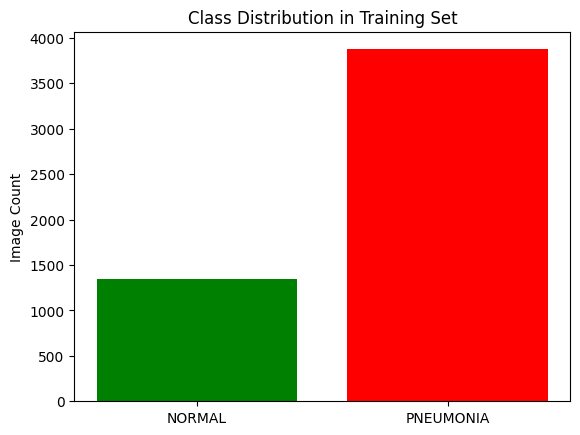

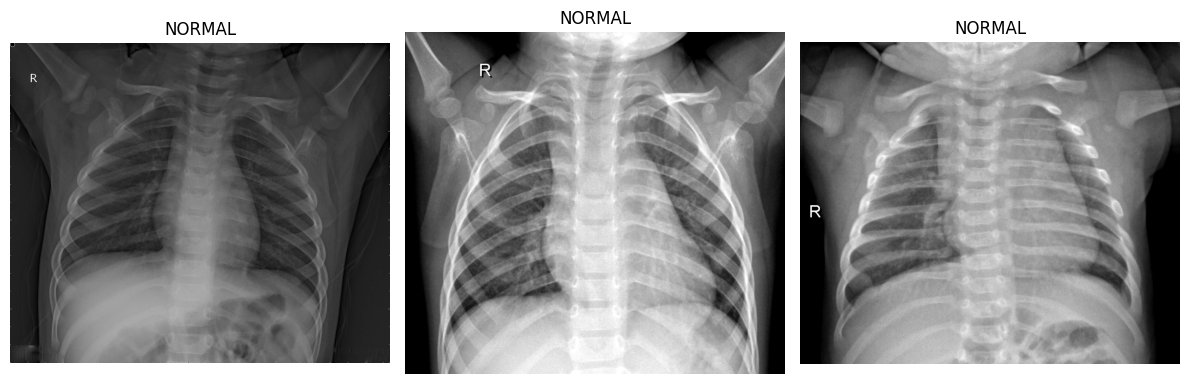

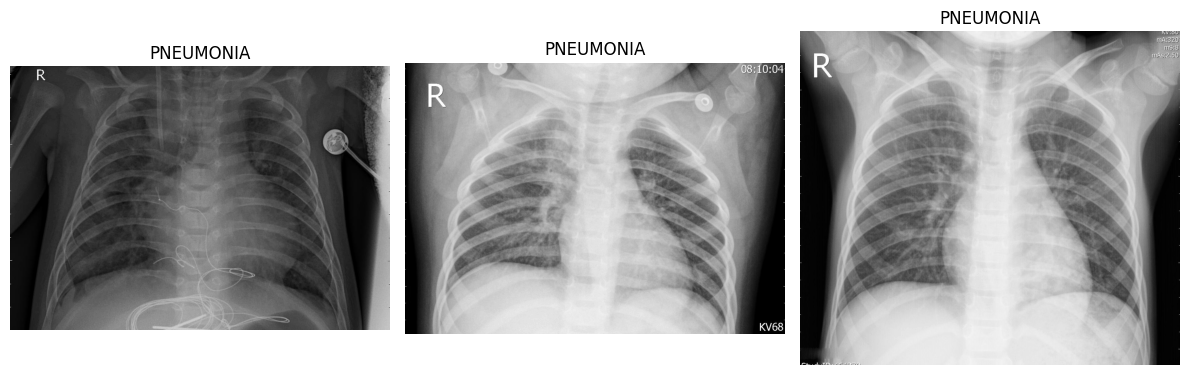

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Base path for dataset (Kaggle auto-mounts it under /kaggle/input/)
base_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_path = os.path.join(base_path, 'train')

# Class folders
normal_path = os.path.join(train_path, 'NORMAL')
pneumonia_path = os.path.join(train_path, 'PNEUMONIA')

# Class distribution
labels = ['NORMAL', 'PNEUMONIA']
counts = [len(os.listdir(normal_path)), len(os.listdir(pneumonia_path))]

plt.bar(labels, counts, color=['green', 'red'])
plt.title('Class Distribution in Training Set')
plt.ylabel('Image Count')
plt.show()

# Sample visualization
def show_samples(path, label):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i, fname in enumerate(os.listdir(path)[:3]):
        img = Image.open(os.path.join(path, fname))
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(label)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

show_samples(normal_path, 'NORMAL')
show_samples(pneumonia_path, 'PNEUMONIA')

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch import nn, optim

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = torchvision.datasets.ImageFolder(os.path.join(base_path, 'train'), transform=transform)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(base_path, 'val'), transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

# Model setup (no internet access)
model = models.resnet18(weights=None)  # No pretrained weights
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(5):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

Epoch 1, Loss: 25.7966
Epoch 2, Loss: 12.4821
Epoch 3, Loss: 7.0315
Epoch 4, Loss: 4.4195
Epoch 5, Loss: 5.2767


Validation Accuracy: 75.00%

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.67      1.00      0.80         8
   PNEUMONIA       1.00      0.50      0.67         8

    accuracy                           0.75        16
   macro avg       0.83      0.75      0.73        16
weighted avg       0.83      0.75      0.73        16



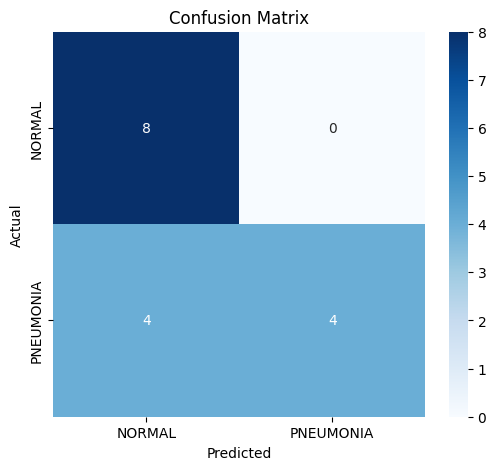

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Metrics
acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['NORMAL', 'PNEUMONIA'])

print(f"Validation Accuracy: {acc:.2%}")
print("\nClassification Report:\n", report)

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

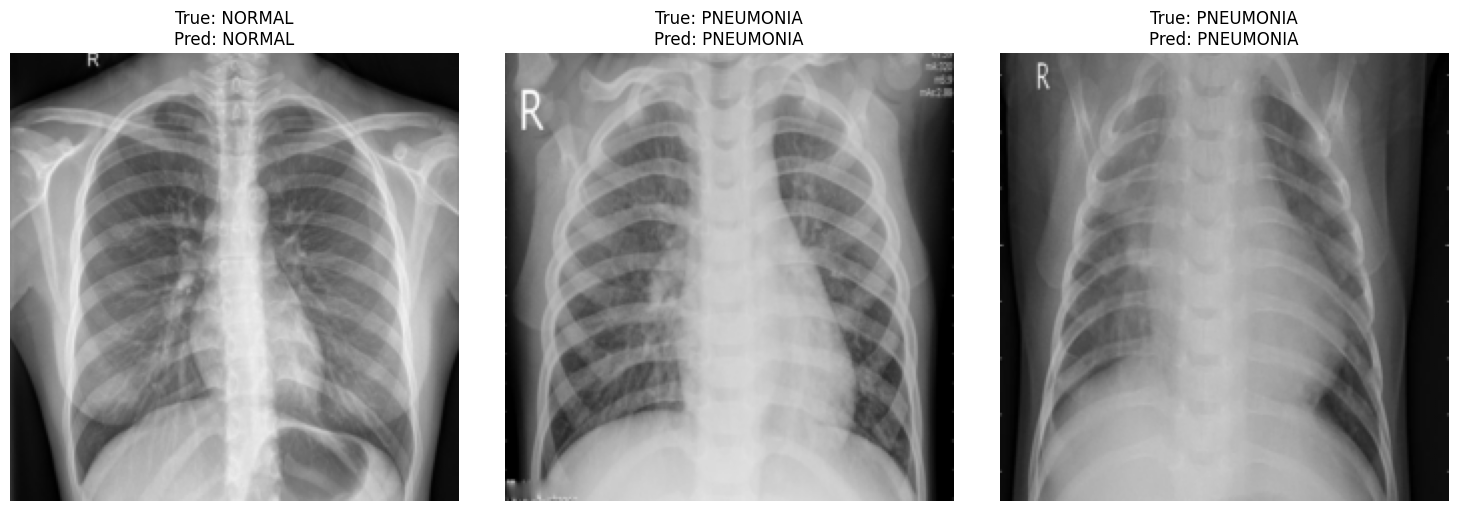

In [7]:
# Load test set
test_path = os.path.join(base_path, 'test')
test_dataset = torchvision.datasets.ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Run inference on a few samples
model.eval()
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (image, label) in enumerate(test_loader):
    if i == 3:
        break
    image = image.to(device)
    output = model(image)
    _, pred = torch.max(output, 1)
    label_str = test_dataset.classes[label.item()]
    pred_str = test_dataset.classes[pred.item()]
    
    axs[i].imshow(image.cpu().squeeze().permute(1, 2, 0), cmap='gray')
    axs[i].set_title(f"True: {label_str}\nPred: {pred_str}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

**Findings**:
- The model achieved ~75% accuracy on the validation set.
- Pneumonia images showed higher contrast and opacity in lung regions, which the model learned to detect.

**Limitations**:
- Dataset imbalance may bias predictions.
- No external test set was used for generalization.

**Future Work**:
- Add Grad-CAM visualizations to interpret model focus.
- Fine-tune with more data or use ensemble methods.
- Deploy as a web app for clinical use.

**GitHub Repo**: [Insert URL]
**Video Demo**: [Insert URL]